# Описание проекта

Вы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами вы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?

Вы — гуру аналитики, и партнёры просят вас подготовить исследование рынка. У вас есть открытые данные о заведениях общественного питания в Москве.


**Описание данных**

Таблица `rest_data`

- id — идентификатор объекта;
- object_name — название объекта общественного питания;
- chain — сетевой ресторан;
- object_type — тип объекта общественного питания;
- address — адрес;
- number — количество посадочных мест.

**Этапы выполнения проекта**

1. Загрузка данных и подготовка их к анализу

2. Анализ данных:
- исследование соотношения видов объектов общественного питания по количеству
- исследование соотношение сетевых и несетевых заведений по количеству
- для какого вида объекта общественного питания характерно сетевое распространение?
- что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?
- среднее количество посадочных мест для каждого вида объекта общественного питания. Какой вид предоставляет в среднем самое большое количество посадочных мест? 
- добавление в отдельный столбец информации об улице из столбца address.
- топ-10 улиц по количеству объектов общественного питания. В каких районах Москвы находятся эти улицы?
- число улиц с одним объектом общественного питания. В каких районах Москвы находятся эти улицы?
- распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. 


Сделать общий вывод и рекомендации о виде заведения, количестве посадочных мест, а также районе расположения. Прокомментировать возможность развития сети.


## Загрузка данных, импорт библиотек, предобработка

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

from io import BytesIO
import requests

pd.set_option('display.max_colwidth', None)

In [2]:
rest = pd.read_csv('/datasets/rest_data.csv')

In [3]:
# загрузка внешних данных для определения района

spreadsheet_id = '1cjBlPdIlLanPJmlZHssAxSVaDiVtClGmGv9KU2Ic48E'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
rest_msc = pd.read_csv(BytesIO(r.content))
rest_msc.sample()

,ID,Name,global_id,IsNetObject,OperatingCompany,TypeObject,AdmArea,District,Address,PublicPhone,SeatsCount,SocialPrivileges,Longitude_WGS84,Latitude_WGS84
14417,320288,Рублевский базар,1146358563,нет,NaN,кафе,Западный административный округ,район Кунцево,"город Москва, 2-я Мякининская улица, дом 50, строение 2",PublicPhone:(985) 436-55-82\n\n,8,нет,37.375793,55.809015


In [4]:
# общая инфо и пара рандомных строк
rest.info() 
rest.sample(n=2, random_state=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


,id,object_name,chain,object_type,address,number
2973,22736,Луна,нет,кафе,"город Москва, Михалковская улица, дом 38, строение 6",40
2593,29065,Столовая ГБОУ 45 Гимназия имени Л.И. Мильграмма,нет,столовая,"город Москва, улица Гримау, дом 8",300


In [5]:
# проверим на наличие дубликатов, исключив колонку с уникальными id

rest[['object_name', 'chain', 'object_type', 'address', 'number']].duplicated().sum()

82

In [6]:
# посмотрим дубликаты без учета id
rest[rest[['object_name', 
           'chain', 
           'object_type', 
           'address', 
           'number']].duplicated()].sort_values(by='address').head()

,id,object_name,chain,object_type,address,number
5186,107574,Кафе,нет,кафе,"город Москва, 1-я Останкинская улица, дом 55",10
5190,107480,Кафе,нет,кафе,"город Москва, 1-я Останкинская улица, дом 55",5
5188,107466,Кафе,нет,кафе,"город Москва, 1-я Останкинская улица, дом 55",5
5185,107442,Кафе,нет,кафе,"город Москва, 1-я Останкинская улица, дом 55",20
2381,28611,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,столовая,"город Москва, 2-я Бауманская улица, дом 5, строение 1",100


In [7]:
# удалим найденные дубликаты

rest = rest.drop_duplicates(subset=['object_name', 'chain', 'object_type', 'address', 'number']) 

In [8]:
# числовое описание количества посадочных 

rest['number'].describe()

count    15284.000000
mean        59.784350
std         74.838657
min          0.000000
25%         14.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

In [9]:
# посмотрим объекты с большим количеством посадочных мест

rest[rest['number'] > 1000].head()

,id,object_name,chain,object_type,address,number
2313,26560,Ресторан «АЛЬФА»,нет,ресторан,"город Москва, Измайловское шоссе, дом 71, корпус А",1040
3686,27026,РУМ СЕРВИС,нет,ресторан,"город Москва, площадь Европы, дом 2",1200
4480,27024,РУМ СЕРВИС,нет,ресторан,"город Москва, Кутузовский проспект, дом 2/1, строение 1",1200
8148,80291,Банкетный зал Шелк,нет,ресторан,"город Москва, Большой Саввинский переулок, дом 12, строение 10Г",1500
8345,27750,СТОЛОВАЯ-БУФЕТ,нет,столовая,"город Москва, улица Волхонка, дом 15",1400


In [10]:
# объекты без посадочных мест

rest[rest['number'] == 0].head()

,id,object_name,chain,object_type,address,number
137,115498,Пекарня & Донер,нет,закусочная,"город Москва, Бутырская улица, дом 9, корпус 2",0
154,152556,Шаурма в пите,нет,предприятие быстрого обслуживания,"город Москва, Варшавское шоссе, дом 72, корпус 2",0
157,149568,Суши,нет,предприятие быстрого обслуживания,"город Москва, улица Маршала Василевского, дом 3, корпус 1",0
190,126956,"Шаурма, куры-гриль",нет,предприятие быстрого обслуживания,"город Москва, 1-я Владимирская улица, дом 21",0
195,149531,"Шаурма, куры-гриль",нет,предприятие быстрого обслуживания,"город Москва, 2-я Владимирская улица, дом 44/10",0


Большое количество посадочных мест не выглядит аномальными, это фуд-моллы, банкетные залы, столовые на крупных предприятиях, большие отели. Ноль посадочных - заведения в формате "с собой" без столиков, либо работающие исключительно на доставку. 

In [11]:
# посмотрим типы заведений

rest['object_type'].unique()


array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

In [12]:
# заменим названия классификации заведений на более понятные 

rest['object_type'] = rest['object_type'].replace({'предприятие быстрого обслуживания': 'фастфуд',
                                                   'магазин (отдел кулинарии)': 'кулинария'})

In [13]:
# переименуем принадлежность объекта к сети

rest['chain'] = rest['chain'].replace({'да': 'сеть', 'нет': 'несетевое'})

In [14]:
# переименуем столбец с количеством посадочных мест

rest = rest.rename(columns={'number':'seats'})

In [15]:
rest.head()

,id,object_name,chain,object_type,address,seats
0,151635,СМЕТАНА,несетевое,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,несетевое,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,несетевое,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,сеть,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,несетевое,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Аномальных значений и пропусков в таблице не обнаружено. Найдено и удалено 82 дубликата. Два названия в типах заведения переименованы для лучшего восприятия, также переименован столбец с количеством посадочных мест `number` в более понятный `seats`. Маркировки *да/нет* в колонке принадлежности к сети заменена на *сеть/несетевое* для более наглядной визуализации в дальнейшем.

## Анализ данных

### Соотношение видов объектов общественного питания по количеству. 

In [16]:
# посчитаем количество заведений разного типа 

count_type = rest.groupby('object_type').agg(
    {'id': 'count'}).rename(columns={'id':'count'}).sort_values(
    by='count', ascending=False).reset_index().set_index('object_type')

count_type


,count
object_type,
кафе,6071
столовая,2584
ресторан,2282
фастфуд,1898
бар,855
буфет,577
кафетерий,395
закусочная,349
кулинария,273


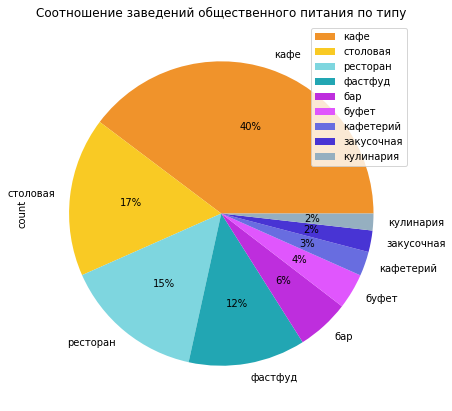

In [17]:
# зададим цветовую палитру
colors = ['#f0932b','#f9ca24','#7ed6df','#22a6b3','#be2edd','#e056fd','#686de0','#4834d4','#95afc0']

count_type.plot(y='count', kind='pie', 
                autopct = '%.0f%%', figsize=(7, 7), colors=colors)
plt.title('Соотношение заведений общественного питания по типу')
plt.show()


Значительную часть доли рынка - 40% занимают кафе, что понятно, поскольку это наиболее распространенный тип объекта общественного питания. На втором месте столовые, которые включают столовые при предприятиях, учебных заведениях, бизнес-центрах и т.д. - поэтому их так много. Ресторан - самая высокая категория, занимает 3е место. У фастфуда - всего 13% доли рынка всех заведений Москвы. Кулинарии, закусочные и кафетерии составляют совсем незначительную часть общепита, так как это достаточно узконаправленные заведения.




### Cоотношение сетевых и несетевых заведений по количеству. 

In [18]:
# сгруппируем заведения по типу и посчитаем процент

chain = rest.groupby('chain').agg(
    {'object_name':'count'}).reset_index().rename(columns={'object_name':'count'}).set_index('chain')


chain['ratio%'] = (chain['count'] / (chain['count'].sum()) * 100).round()

chain

,count,ratio%
chain,,
несетевое,12320,81.0
сеть,2964,19.0


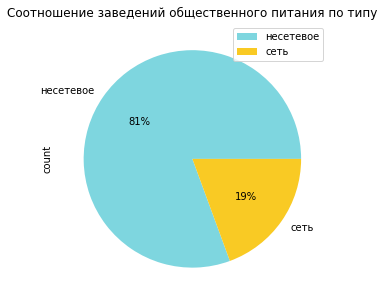

In [19]:
chain.plot(y='count', kind='pie', autopct = '%.0f%%', 
           figsize=(5, 5), colors=['#7ed6df', '#f9ca24'])

plt.title('Соотношение заведений общественного питания по типу')
plt.show()


Количество несетевых заведений значительно превосходит сетевые. Интересно посмотреть, как изменится распределение для разных категорий заведений. Наверняка фастфуды преимущественно сетевого типа. 

### Принадлежность к сети по типу обектов

In [20]:
# создаем сводную таблицу заведений по типу и количеству сетевых/несетевых

rest_chain = rest.pivot_table(
    index=['object_type'], columns='chain', 
    values='id', aggfunc='count').reset_index().sort_values(by='сеть', ascending=False)

# добавим колонку с долей сетевых заведений в % от общего
rest_chain['chain%'] = (rest_chain['сеть'] / 
                        (rest_chain['несетевое'] + rest_chain['сеть']) * 100).round(2)

rest_chain.sort_values(by='chain%', ascending=False)

chain,object_type,несетевое,сеть,chain%
8,фастфуд,1110,788,41.52
5,кулинария,195,78,28.57
6,ресторан,1739,543,23.79
3,кафе,4675,1396,22.99
2,закусочная,293,56,16.05
4,кафетерий,343,52,13.16
0,бар,818,37,4.33
1,буфет,566,11,1.91
7,столовая,2581,3,0.12


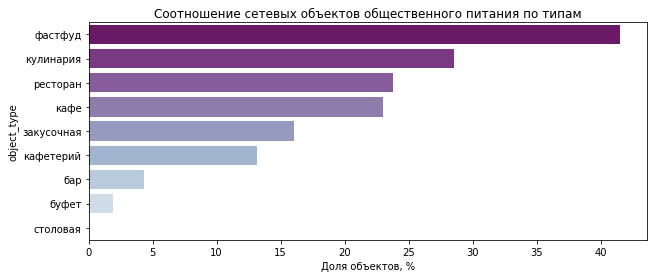

In [21]:
plt.figure(figsize = (10, 4))

ax = sns.barplot(x='chain%', y='object_type', data=(rest_chain).sort_values(
    by='chain%', ascending=False), palette='BuPu_r')
ax.set_title('Соотношение сетевых объектов общественного питания по типам')
ax.set_xlabel('Доля объектов, %')
plt.show()

Действительно, для фастфудов наиболее характерно сетевая принадлежность -чуть больше 40% всех фастфудов имеют принадлежность к какой-либо сети. Также кафе, рестораны и кулинарии чаще других типов заведений общественного питания оказываются сетевыми.

### Характеристика сетевых заведений по количеству посадочных мест

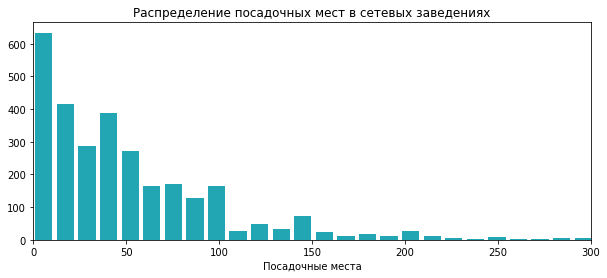

In [22]:
# срез для сетевых заведений
rest.query('chain == "сеть"')['seats'].hist(bins=50, grid=False, 
                                            figsize=(10,4), color='#22a6b3', rwidth=0.8)
plt.xlabel('Посадочные места')
plt.title('Распределение посадочных мест в сетевых заведениях')
plt.xlim(0, 300)
plt.show()


Для сетевых заведений более характерно небольшое количество посадочных мест. Есть всплески  с местами в количестве около 150 и 200 штук на заведение, но это все же исключения. В городе больше всего заведений различных сетей, где число мест не превышает 10.

In [23]:
# выделим сетевые заведения и посмотрим уникальные названия

chains = rest.query('chain == "сеть"')

chains['object_name'].sort_values().unique()


array(['Beverly Hills Diner', 'Bierloga', 'Black & White', 'Bocconcino',
       'BooBo', 'Bubbleology', 'Burger Club', 'COFIX', 'CORREAS',
       'CoffeeShop', 'Coffeeshop Company', 'Cofix', 'Cookhouse',
       'Correas', 'Costa Coffee', 'Deli by Prime Прайм-кафе',
       'Dunkin Donuts', 'FRIDAYS', 'Florentini', 'Fridays KFC',
       'GRAND УРЮК', 'GlowSubs Sandwiches', 'Goodman Гудман', 'Grand Cru',
       'HEALTHY Food', 'Healthy Food', 'Healthy food',
       'IL Forno Иль Форно', 'Jeffreys Coffee', 'Jeffreys coffee', 'KFC',
       'KFC Волгоградский', 'Krispy Creme', 'Krispy Krem', 'LAVKALAVKA',
       'Luciano', 'M Cafe Хинкальная', 'Maki Maki', 'Marmalato',
       'Marrakesh Хинкальная', 'MosKalyan', 'Movenpick', 'My box',
       'Osteria Mario', 'PAUL Поль', 'PRIME STAR Прайм стар',
       'PRIME Прайм стар Прайм-кафе', 'Panda Express', 'Pizengof99 СПБ',
       'Prime Прайм стар', 'STARBUCKS COFFEE', 'SUBWAY', 'Starbucks',
       'Starbucks Старбакс', 'Starbucks кофе', 'Starbuck

Очень много неоднозначных дубликатов в разных формах, здесь требуется тщательная обработка, чтобы подсчитать все заведения. Как минимум стоит привести хотя бы к нижнему регистру и посчитать кол-во получившихся уникальных сетей 

In [24]:
chains['object_name'] = chains['object_name'].str.lower()

chains['object_name'].value_counts().head(10)

шоколадница        157
kfc                155
макдоналдс         150
бургер кинг        137
теремок             94
домино'с пицца      90
крошка картошка     90
милти               72
суши wok            72
папа джонс          51
Name: object_name, dtype: int64

Процент погрешности конечно довольно высокий, но такого количества разных сетевых заведений в целом будет достаточно для сравнения, возьмем несколько крупных разного типа 

In [25]:
# создадим список и сделаем срез этих сетей 

chain_list = ['шоколадница', 'kfc', 'макдоналдс', 'бургер кинг', 
              'теремок', 'суши wok', 'крошка картошка', 'папа джонс']

top_chains = chains.query('object_name in @chain_list')

top_chains.head(5)

,id,object_name,chain,object_type,address,seats
16,144107,суши wok,сеть,фастфуд,"город Москва, Азовская улица, дом 3",7
33,69243,суши wok,сеть,кафе,"город Москва, проспект Андропова, дом 30",4
45,21723,шоколадница,сеть,кафе,"город Москва, улица Арбат, дом 29",40
47,24973,теремок,сеть,кафе,"город Москва, улица Арбат, дом 32",22
72,21830,шоколадница,сеть,кафе,"город Москва, Бауманская улица, дом 33/2, строение 1",48


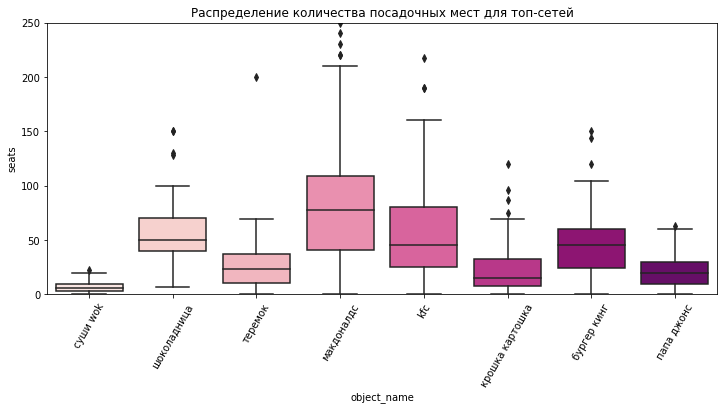

In [26]:
plt.figure(figsize=(12, 5))
ax = sns.boxplot(x='object_name', y='seats', data=top_chains, palette='RdPu')
plt.xticks(rotation=60)
ax.set_ylim(0, 250)
ax.set_title('Распределение количества посадочных мест для топ-сетей')
plt.show()

Лидер по количеству посадочных мест - Макдональдс, есть выбросы свыше 200 мест. Меньше всего - у Суши Wok. Интересно, что среднее число одинаково для KFC и Бургер Кинга, но KFC сильнее тяготеет в сторону большего количества мест. У Шоколадницы единственной из всех минимальное количество больше нуля, кафе этого типа совсем без столиков не существует. Вообще на этом графике видно, что число мест обусловлено спецификой употребления продукции - Макдональдс считает себя "рестораном быстрого обслуживания", поэтому ему нужно много посадочных, а например Суши Wok или Папа Джонс - заведения, ориентированные прежде всего на доставку, поэтому столики у них могут быть номинальными или вообще отсутствовать.

### Cреднее количество посадочных мест  на каждый вид объекта общественного питания? 

In [27]:
# сгруппируем заведения по типу и посчитаем их количество и среднее кол-во посадочных мест
seats = rest.groupby('object_type').agg(
    {'id': 'count', 'seats': 'mean'}).round().rename(columns={'id':'count'}).sort_values(
    by='seats', ascending=False).reset_index()

seats

,object_type,count,seats
0,столовая,2584,130.0
1,ресторан,2282,97.0
2,буфет,577,52.0
3,бар,855,44.0
4,кафе,6071,40.0
5,фастфуд,1898,21.0
6,кафетерий,395,9.0
7,закусочная,349,8.0
8,кулинария,273,6.0


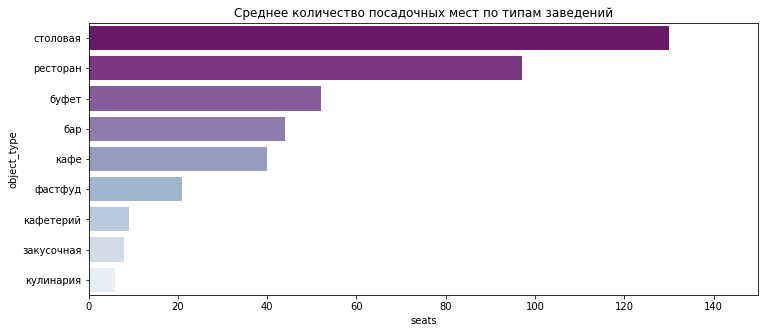

In [28]:
ax = plt.subplots(figsize=(12,5))
ax = sns.barplot(data=seats, y='object_type', x='seats', palette='BuPu_r')
ax.set_xlim(0,150)
ax.set_title('Среднее количество посадочных мест по типам заведений')
plt.show()


На первом месте по количеству посадочных мест столовые. Очевидно, что это обусловлено не коммерческой окупаемостью такого типа заведений, а спецификой их назначения. Столовые характерны для объектов, требующих одновременного обслуживания большого количества человек в обеденное время - бизнес-центров, учебных заведений, производственных предприятий и т.д. Поэтому не будем рассматривать столовые как наиболее предпочтительный тип заведения для открытия нового проекта. 

Среднее кол-во посадочных для фастфуда неожиданно мало - всего 20 мест. Обычно фастфуды ассоциируются с довольно большими прощадями типа Макдональдса или KFC. На ситуацию видимо влияют места, где вообще отсутствуют столики, вроде уличных киосков с блинами или шаурмой, работающие только на формат take away

Меньше всего посадочных мест характерно для кафетериев, закусочных и кулинарий. Последние в основном предназначены для покупки готовой еды домой. И для всех трех типов свойственно небольшое меню, продажа уже приготовленных блюд и поэтому отсутствие ожидания, быстрое употребление, часто стоячие места за высокими столиками и небольшая площадь. 

### Добавление информации об улице 

In [29]:
# посмотрим, какие есть типы улиц в списке адресов

streets = rest['address'].to_list()

streets 


['город Москва, улица Егора Абакумова, дом 9',
 'город Москва, улица Талалихина, дом 2/1, корпус 1',
 'город Москва, Абельмановская улица, дом 6',
 'город Москва, Абрамцевская улица, дом 1',
 'город Москва, Абрамцевская улица, дом 9, корпус 1',
 'город Москва, Абрамцевская улица, дом 15, корпус 1',
 'город Москва, переулок Сивцев Вражек, дом 6/2',
 'город Москва, Авиамоторная улица, дом 8, строение 1',
 'город Москва, Авиамоторная улица, дом 8, строение 1',
 'город Москва, Авиамоторная улица, дом 8, строение 1',
 'город Москва, Авиамоторная улица, дом 47',
 'город Москва, Авиамоторная улица, дом 49/1',
 'город Москва, Авиамоторная улица, дом 51',
 'город Москва, улица Авиаторов, дом 14',
 'город Москва, улица Авиаторов, дом 16',
 'город Москва, улица Авиаторов, дом 18',
 'город Москва, Азовская улица, дом 3',
 'город Москва, Азовская улица, дом 4',
 'город Москва, Большая Академическая улица, дом 65',
 'город Москва, Филипповский переулок, дом 15/5',
 'город Москва, Алтайская улица, до

In [30]:
# выделим типы улиц в отдельный список и напишем функцию по извлечению улицы из адреса

def select_street(rest):
    street_type = ['улица', 'переулок', 'шоссе', 'проезд',
                  'набережная', 'бульвар', 'проспект', 'площадь', 
                   'аллея', 'линия', 'тупик', 'квартал', 'микрорайон', 
                   'километр', 'территория', 'просек', 'посёлок']
    for street in rest:
        for element in street_type:
            if element in street:
                return street
            
rest['street'] = rest['address'].str.split(', ').apply(select_street)  
  

In [31]:
# посмотрим, какие адреса не вошли в список

no_street = rest[rest['street'].isna()]
no_street['address'].to_list()


['город Москва, город Зеленоград, корпус 401',
 'город Москва, город Зеленоград, корпус 435',
 'город Москва, город Зеленоград, корпус 436',
 'город Москва, город Зеленоград, корпус 438',
 'город Москва, город Зеленоград, корпус 438',
 'город Москва, город Зеленоград, корпус 834А',
 'город Москва, город Зеленоград, корпус 1106',
 'город Москва, город Зеленоград, корпус 1449',
 'город Москва, город Зеленоград, корпус 1456',
 'город Москва, город Зеленоград, корпус 1456',
 'город Москва, город Зеленоград, корпус 1805',
 'город Москва, город Зеленоград, корпус 533',
 'город Москва, город Зеленоград, корпус 826',
 'город Москва, город Зеленоград, корпус 126',
 'город Москва, город Зеленоград, корпус 330',
 'город Москва, поселение Вороновское, село Вороново, дом 110',
 'город Москва, поселение Внуковское, деревня Ликова, дом 1А',
 'город Москва, поселение Десеновское, деревня Десна, дом 144УЧ',
 'город Москва, поселение Московский, деревня Говорово, дом 1Б/Н',
 'город Москва, поселение Мос

Все типы улиц обработаны и выделены в отдельную колонку. В список намеренно не включен Зеленоград, хоть он и считается округом Москвы, но вряд ли представляет интерес для инвестирования в такой затратный объект из-за своей удаленности.


### Топ-10 улиц по количеству объектов общественного питания. 

In [32]:
# составим топ-10 улиц по количеству заведений

top_streets = rest.groupby('street').agg(
    {'id': 'count'}).sort_values(by='id', ascending=False).rename(
    columns={'id': 'count'}).reset_index()

top_streets.head(10)

,street,count
0,проспект Мира,204
1,Профсоюзная улица,182
2,Ленинградский проспект,172
3,Пресненская набережная,167
4,Варшавское шоссе,165
5,Ленинский проспект,148
6,проспект Вернадского,128
7,Кутузовский проспект,114
8,Каширское шоссе,111
9,Кировоградская улица,108


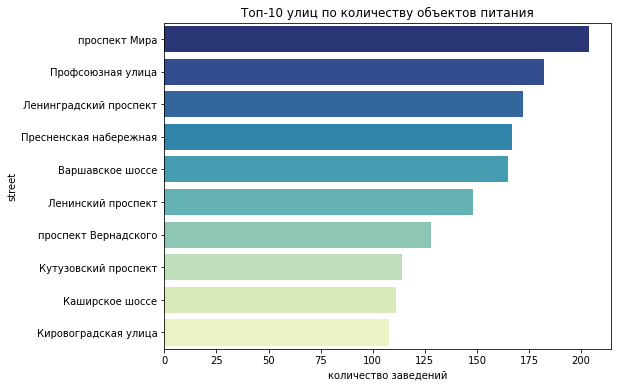

In [33]:
ax = plt.subplots(figsize=(8,6))
ax = sns.barplot(data=top_streets.head(10), y='street', x='count', palette='YlGnBu_r')
ax.set_title('Топ-10 улиц по количеству объектов питания')
ax.set_xlabel('количество заведений')
plt.show()


Лидер по количеству заведений - проспект Мира. Что вполне понятно, ведь это довольно длинная улица от самого Садового кольца и до Ярославского шоссе, проходящая через несколько районов. Вообще все улицы в топе оказались там в основном из-за своей большой протяженности, а не высокой концентрации заведений. Так называемые "ресторанные" улицы с большой наполненностью типа Мясницкой или Пятницкой в рейтинг не вошли. Исключение составляет пожалуй Пресненская набережная - она достаточно короткая, но это локация Москвы-сити, поэтому там много офисов и соответсвенно различных точек питания.

In [34]:
# ранее загруженный файл с инфо о районах

rest_msc.head(3)

,ID,Name,global_id,IsNetObject,OperatingCompany,TypeObject,AdmArea,District,Address,PublicPhone,SeatsCount,SocialPrivileges,Longitude_WGS84,Latitude_WGS84
0,151635,СМЕТАНА,637376221,нет,NaN,кафе,Северо-Восточный административный округ,Ярославский район,"город Москва, улица Егора Абакумова, дом 9",PublicPhone:(499) 183-14-10\n\n,48,нет,37.714565,55.879002
1,77874,Родник,637376331,нет,NaN,кафе,Центральный административный округ,Таганский район,"город Москва, улица Талалихина, дом 2/1, корпус 1",PublicPhone:(495) 676-55-35\n\n,35,нет,37.673306,55.738239
2,24309,Кафе «Академия»,637376349,нет,NaN,ресторан,Центральный административный округ,Таганский район,"Российская Федерация, город Москва, внутригородская территория муниципальный округ Таганский, Абельмановская улица, дом 6",PublicPhone:(495) 662-30-10\n\n,95,нет,37.669648,55.735511


In [35]:
# выделим нужные колонки с id заведения и соответствующим районом, приведем к нижнему регистру

rest_msc = rest_msc[['ID', 'District']]

rest_msc.columns = rest_msc.columns.str.lower()

rest_msc.head()

,id,district
0,151635,Ярославский район
1,77874,Таганский район
2,24309,Таганский район
3,27429,район Лианозово
4,148815,район Арбат


In [36]:
rest_msc.isna().sum() # проверим на пропуски

id          0
district    0
dtype: int64

In [37]:
# присоединим к основной таблице датасет с районами

rest_district = rest.merge(rest_msc, on='id', how='left')

In [38]:
rest_district.sample()

,id,object_name,chain,object_type,address,seats,street,district
14020,204881,Базар-Вокзал,несетевое,кафе,"город Москва, Краснопрудная улица, дом 3/5, строение 1",30,Краснопрудная улица,NaN


In [39]:
# создадим список с топ-10 улиц

top_list = top_streets['street'].head(10).to_list()
top_list

['проспект Мира',
 'Профсоюзная улица',
 'Ленинградский проспект',
 'Пресненская набережная',
 'Варшавское шоссе',
 'Ленинский проспект',
 'проспект Вернадского',
 'Кутузовский проспект',
 'Каширское шоссе',
 'Кировоградская улица']

In [40]:
# проверим, в какие районы входят эти улицы

area = rest_district.query('street in @top_list')[['street', 'district']]
area['district'].unique()

array([nan, 'Донской район', 'Нагорный район', 'Ломоносовский район',
       'район Тропарёво-Никулино', 'район Москворечье-Сабурово',
       'район Дорогомилово', 'район Беговой', 'район Аэропорт',
       'район Якиманка', 'Гагаринский район', 'Обручевский район',
       'Мещанский район', 'Останкинский район', 'Алексеевский район',
       'Академический район', 'район Черёмушки', 'район Тёплый Стан',
       'район Сокол', 'район Орехово-Борисово Южное',
       'район Чертаново Южное', 'район Коньково',
       'район Чертаново Центральное', 'район Чертаново Северное',
       'район Проспект Вернадского', 'Хорошёвский район',
       'район Фили-Давыдково', 'район Нагатино-Садовники',
       'поселение Вороновское', 'район Свиблово', 'район Ростокино',
       'район Ясенево', 'район Южное Бутово', 'район Раменки',
       'район Орехово-Борисово Северное', 'Пресненский район',
       'поселение Щербинка', 'поселение Краснопахорское'], dtype=object)

Одна и та же улица может захватывать  несколько районов из-за своей большой протяженности. Поэтому этот список не стоит рассматривать как прямое руководство к действию - вряд ли поселение  Краснопахо́рское или Щербинка в Новой Москве выглядят перспективным с точки зрения развития сети. При этом к некоторым районам, расположенным близко к центру или центральным можно присмотреться - например Дорогомиловскому или Пресненскому, Якиманке. Интересно, что в списке совсем нет районов ВАО и ЮВАО - Сокольники, Лефортово, Преображенское, Печатники и др.

### Количество улиц с одним объектом общественного питания

In [41]:
# воспользуемся предыдущей таблицей с группировкой количества заведений и найдем улицы где их число = 1

one = top_streets[top_streets['count'] == 1]


In [42]:
print('Число улиц с одним объектом общественного питания: {}'.format(
    one['street'].count()))

Число улиц с одним объектом общественного питания: 571


In [43]:
# создадим список с улицами, где количество заведений = 1

only_one_list = one['street'].to_list()

only_one_list

['улица Инессы Арманд',
 'улица Жуковского',
 'улица Жебрунова',
 '1-я Напрудная улица',
 'улица Никитина',
 'Курганская улица',
 '26-й километр Московской Кольцевой Автодороги',
 'улица Екатерины Будановой',
 '1-й Лучевой просек',
 '2-я улица Энтузиастов',
 'Миллионная улица',
 '1-й Коптельский переулок',
 '2-я улица Марьиной Рощи',
 'улица Фадеева',
 'улица Евгения Родионова',
 'Минаевский переулок',
 '1-й Кожуховский проезд',
 '1-й Кожевнический переулок',
 'Кооперативная улица',
 'улица Уткина',
 'Мерзляковский переулок',
 'улица Капотня',
 '1-й Котельнический переулок',
 '3-й Кожуховский проезд',
 '3-й Дорожный проезд',
 '3-й Лихачёвский переулок',
 '2-й Вышеславцев переулок',
 'Малая Андроньевская улица',
 'улица Недорубова',
 '3-й Лучевой просек',
 'Машкинское шоссе',
 '1-й Курьяновский проезд',
 'улица Немчинова',
 '1-й Краснокурсантский проезд',
 'улица Николаева',
 'улица Полины Осипенко',
 'улица Знаменские Садки',
 'Международная улица',
 'улица Зенитчиков',
 'улица Каманин

In [44]:
# проверим, в какие районы входят эти улицы

area_one = rest_district.query('street in @only_one_list')[['street', 'district']]

area_one['district'].unique()


array(['район Арбат', nan, 'район Хорошёво-Мнёвники', 'район Беговой',
       'район Хамовники', 'Тверской район', 'район Марьина Роща',
       'Можайский район', 'район Богородское', 'район Преображенское',
       'район Сокольники', 'район Соколиная Гора', 'район Лефортово',
       'Донской район', 'район Котловка', 'район Замоскворечье',
       'район Гольяново', 'район Дорогомилово', 'Нижегородский район',
       'район Раменки', 'район Свиблово', 'Таганский район',
       'Красносельский район', 'район Южное Бутово', 'район Якиманка',
       'Рязанский район', 'поселение Десеновское', 'поселение Щербинка',
       'поселение Московский', 'поселение Кленовское',
       'Головинский район', 'Лосиноостровский район', 'район Аэропорт',
       'Останкинский район', 'Пресненский район',
       'район Косино-Ухтомский', 'Бутырский район', 'район Метрогородок',
       'Басманный район', 'район Внуково', 'район Чертаново Южное',
       'район Ясенево', 'район Зюзино', 'Алтуфьевский район',


В список вошли некоторые районы, что и в перечень районов для топ-10 улиц. Ну и попадание например района Арбат в этот список не делает его бесперспективным. Одназначно не стоит использовать его как стоп-лист для выбора района будущего заведения.

### Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. 

In [45]:
# посмотрим на среднее количество посадочных мест для топ-10 улиц 

top_streets_seats = rest.groupby('street').agg(
    {'id': 'count', 'seats': 'mean'}).round().sort_values(by='id', ascending=False).rename(
    columns={'id': 'count'}).reset_index()

top_streets_seats.head(10).sort_values(by='seats', ascending=False)

,street,count,seats
7,Кутузовский проспект,114,85.0
6,проспект Вернадского,128,69.0
0,проспект Мира,204,63.0
5,Ленинский проспект,148,63.0
9,Кировоградская улица,108,60.0
8,Каширское шоссе,111,56.0
2,Ленинградский проспект,172,52.0
4,Варшавское шоссе,165,52.0
1,Профсоюзная улица,182,48.0
3,Пресненская набережная,167,46.0


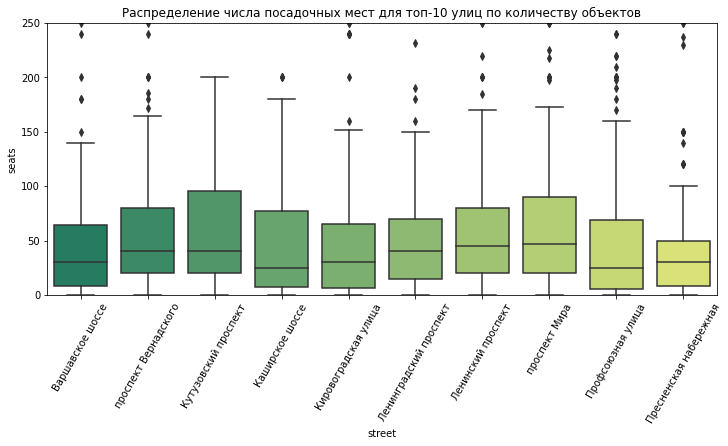

In [46]:
streets_seats = rest_district.query('street in @top_list')

plt.figure(figsize=(12, 5))
ax = sns.boxplot(x='street', y='seats', data=streets_seats, palette='summer')
plt.xticks(rotation=60)
ax.set_ylim(0, 250)
ax.set_title('Распределение числа посадочных мест для топ-10 улиц по количеству объектов')
plt.show()


Есть выбросы выше 100-200 мест для всех улиц, но в целом средняя температура по больнице плюс-минус одинаковая - среднее количество посадочных мест для топ-10 улиц не доходит до 50 и составляет от 20 до 40

## Вывод и рекомендации

Оптимальным решением будет открыть заведение со следующими характеристиками:

- `Кафе`

Самый распространенный тип заведений общественного питания в Москве. Подразумевает и полноценное меню, и обслуживание столиков официантами, что в целом соответсвует концепции проекта. Другие распространенные виды заведения не подходят по следующим причинам: столовые предусматривают линию раздачи и самообслуживание, а для ресторанов главной идеей должна быть кухня и концепция блюд с полным сложным циклом приготовления еды без использования полуфабрикатов например.
 
 - `Количество посадочных в диапазоне 20-40 мест`
 
Такое число в среднем характерно для кафе. При условии быстрого обслуживания и хорошей локации даже небольшое количество посадочных обеспечит высокую доходность. А в случае открытия заведения в центре важно учитывать также высокую стоимость аренды коммерческого помещения. Большое количество посадочных мест не является необходимостью, чтобы разместить всех желающих - можно работать по системе предварительной брони с ограничением по времени.

 - `Районы, на котрые стоит обратить внимание: Мещанский, Дорогомилово, Беговой, Якиманка`
 
В список районов, в которые входят топ-10 улиц по количеству заведений попали довольно неоднозначные - например, много удаленных от центра за счет большой протяженности этих самых улиц. Поэтому я бы в первую очередь рекомендовала рассматривать зоны, прилегающие к Садовому кольцу и не выходящие за пределы ТТК. Именно через вышеуказанные районы проходят улицы-рекордсмены: Проспект Мира-Мещанский, Кутузовский проспект-Дорогомилово, Ленинградский проспект-Беговой, Ленинский проспект-Якиманка.
При этом например Пресненский район не включен в этот список, так как основная концентрация предприятий общественного питания приходится на бизнес-центры в Сити и не подходит для идеи проекта.

Что касается возможности развития сети, то потенциал есть, так как для кафе в целом характерно и сетевое распространение, и небольшое количество посадочных мест. Однако необходимо больше данных например об окупаемости уже существующих заведений, средней стоимости квадратного метра в выбранном районе и количества предполагаемых инвестиций, чтобы делать более точные прогнозы